In [83]:
%matplotlib inline
import sys
from collections import Counter
import re
import random

import pandas as pd
import matplotlib.pyplot as plt

from mecab import MeCab

from sklearn.model_selection import train_test_split

### DATA

1. 텍스트 데이터 분석 
2. 에러 데이터 생성

In [2]:
df = pd.read_csv('../../data/raw/colloquial_ko.csv')

In [3]:
df.head()

,tgt
0,"그 말을 들으니 기쁘고, 저희와 거래하는 것을 고려해 주셨으면 합니다."
1,"확실히 생각하고 있습니다만, 몇 가지 여쭤보고 싶은 게 있어요."
2,"그들에게 말하면, 저희가 그 아이들을 돌볼 것입니다."
3,"좋아요, 수영은 어떤가요?"
4,현재 두 개의 수영장이 있습니다.


In [4]:
mecab = MeCab()

In [5]:
df['morphs_ko'] = df['tgt'].apply(lambda x: mecab.morphs(str(x)))

In [6]:
df['morphs_length'] = df['morphs_ko'].apply(lambda x: len(x))

In [7]:
df.describe()

,morphs_length
count,1.260280e+06
mean,1.391222e+01
std,5.386720e+00
min,1.000000e+00
25%,1.000000e+01
50%,1.300000e+01
75%,1.700000e+01
max,7.800000e+01


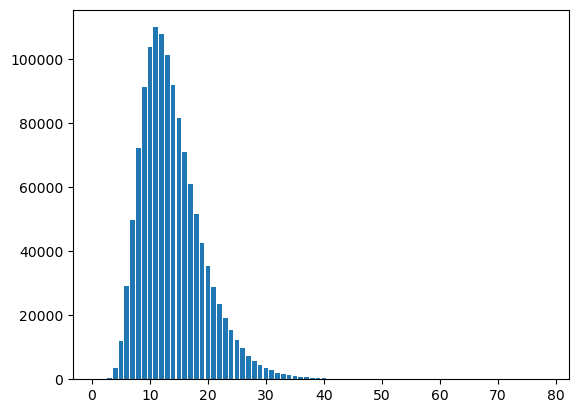

In [28]:
length_list = df['morphs_length'].tolist()
length_list.sort()
length_cnt = Counter(length_list)

x = length_cnt.keys()
y = length_cnt.values()

plt.bar(x, y)
plt.show()

- 텍스트 데이터 형태소 분석 결과 : 대부분 10개(전체 데이터의 약 25%) ~ 17개 (전체 데이터의 약 75%)의 형태소로 이루어져있음.

- 학습 및 테스트 데이터 약 5만개 정도 샘플링 하되 위의 형태소 개수로 이루어진 데이터셋 구축 예정. 

In [29]:
df_idx = [i for i in range(len(df)) if 10 <= df['morphs_length'][i] < 18]

In [30]:
# 약 50만개의 데이터가 걸러짐
print(len(df))
print(len(df_idx))
df2 = df.loc[df_idx]
df2.reset_index(inplace=True, drop=True)

1260280
729137


In [31]:
def random_sampling(df, random_seed:int, sample_num:int, data:str):
    random.seed(random_seed)
    if sample_num > len(df):
        random_sample_index = random.sample(range(len(df)), len(df))
    else:
        random_sample_index = random.sample(range(len(df)), sample_num)

    if data == 'train':
        result_df = df.drop(random_sample_index)
        result_df.reset_index(inplace=True, drop=True)
        return result_df
    elif data == 'test':
        result_df = df.loc[random_sample_index]
        result_df.reset_index(inplace=True, drop=True)
        return result_df 

In [32]:
sample = random_sampling(df2, random_seed=123, sample_num=50000, data = 'test')

In [71]:
sample['replace_morphs_text'] = sample['morphs_ko'].apply(lambda x: ' '.join(x))

In [73]:
with open('colloquial_replace_morphs.txt', 'w') as f:
    for line in sample.replace_morphs_text.values:
        try:
            f.write(line + '\n')
        except:
            print(line)

#### Subword 분절

- 서브워드 분절은 기본적으로 '단어는 의미를 가진 더 작은 서브워드들의 조합으로 이루어진다'는 가정하에 적용되는 알고리즘

- 적절한 서브워드를 발견하여 해당 단위로 쪼개어주면 어휘수를 줄일 수 있고 희소성을 효과적으로 줄일 수 있다.

- 신조어나 오타와 같은 UNK에 대해 서브워드 단위나 문자 단위로 쪼개줌으로써 기존 훈련 데이터에서 보았던 토큰들의 조합으로 만들 수 있다.

- 자연어 전처리에 필수 절차이다.


- Huggingface tokenizer
    - byte level bpe tokenizer
    - char bpe tokenizer
    - sentencepiece bpe tokenizer
    - bert wordpiece tokenizer


- 한국어 Subword 순서
    * src, tgt 둘다 실행.
    
    1. 기존의 띄어쓰기 위치에 '▁' 삽입
    2. Mecab 등의 분절기로 분절후 Subword 수행.

In [74]:
from tokenizers import SentencePieceBPETokenizer, Tokenizer

In [75]:
tokenizer = SentencePieceBPETokenizer()

In [76]:
%%time
# train
min_frequency = 5
vocab_size = 30000

tokenizer.train(["../../data/sample/colloquial_replace_morphs.txt"], vocab_size=vocab_size, min_frequency=min_frequency)
tokenizer




CPU times: user 3.2 s, sys: 1.02 s, total: 4.22 s
Wall time: 514 ms


Tokenizer(vocabulary_size=8138, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [77]:
for t in sample.tgt.values[:10]:
    output = tokenizer.encode(t)
    print(t)
    print(output.ids)
    print(output.tokens)
    print(output.offsets, '\n')

저희 엑스레이 검사 기계를 사용할 수 있습니다.
[1058, 5581, 1441, 2818, 1537, 372, 1099, 942, 1019, 1011, 575, 1003, 10]
['▁저희', '▁엑스', '레이', '▁검사', '▁기계', '를', '▁사용', '할', '▁수', '▁있', '습', '니다', '.']
[(0, 2), (2, 5), (5, 7), (7, 10), (10, 13), (13, 14), (14, 17), (17, 18), (18, 20), (20, 22), (22, 23), (23, 25), (25, 26)] 

출시된지 약 일주일 정도 되었죠.
[1594, 273, 755, 1323, 6135, 1700, 1054, 636, 740, 10]
['▁출시', '된', '지', '▁약', '▁일주일', '▁정도', '▁되', '었', '죠', '.']
[(0, 2), (2, 3), (3, 4), (4, 6), (6, 10), (10, 13), (13, 15), (15, 16), (16, 17), (17, 18)] 

따라서 투자자로서 해야 할 일이 있습니다.
[1613, 3053, 351, 532, 1176, 1033, 1074, 693, 1011, 575, 1003, 10]
['▁따라서', '▁투자자', '로', '서', '▁해야', '▁할', '▁일', '이', '▁있', '습', '니다', '.']
[(0, 3), (3, 7), (7, 8), (8, 9), (9, 12), (12, 14), (14, 16), (16, 17), (17, 19), (19, 20), (20, 22), (22, 23)] 

투어 가이드가 현지 시장으로 안내해 줄 거예요.
[2353, 3004, 69, 2565, 1455, 7544, 2137, 947, 1302, 1064, 651, 666, 10]
['▁투어', '▁가이드', '가', '▁현지', '▁시장', '으로', '▁안내', '해', '▁줄', '▁거', '예', '요', '.']
[(0, 2),

In [78]:
# save
tokenizer.save('../../data/subword_tokenizer/my-tokenizer.json')

In [79]:
# load
tokenizer2 = Tokenizer.from_file("../../data/subword_tokenizer/my-tokenizer.json")

In [80]:
for t in sample.tgt.values[:10]:
    output = tokenizer2.encode(t)
    print(t)
    print(output.ids)
    print(output.tokens)
    print(output.offsets, '\n')

저희 엑스레이 검사 기계를 사용할 수 있습니다.
[1058, 5581, 1441, 2818, 1537, 372, 1099, 942, 1019, 1011, 575, 1003, 10]
['▁저희', '▁엑스', '레이', '▁검사', '▁기계', '를', '▁사용', '할', '▁수', '▁있', '습', '니다', '.']
[(0, 2), (2, 5), (5, 7), (7, 10), (10, 13), (13, 14), (14, 17), (17, 18), (18, 20), (20, 22), (22, 23), (23, 25), (25, 26)] 

출시된지 약 일주일 정도 되었죠.
[1594, 273, 755, 1323, 6135, 1700, 1054, 636, 740, 10]
['▁출시', '된', '지', '▁약', '▁일주일', '▁정도', '▁되', '었', '죠', '.']
[(0, 2), (2, 3), (3, 4), (4, 6), (6, 10), (10, 13), (13, 15), (15, 16), (16, 17), (17, 18)] 

따라서 투자자로서 해야 할 일이 있습니다.
[1613, 3053, 351, 532, 1176, 1033, 1074, 693, 1011, 575, 1003, 10]
['▁따라서', '▁투자자', '로', '서', '▁해야', '▁할', '▁일', '이', '▁있', '습', '니다', '.']
[(0, 3), (3, 7), (7, 8), (8, 9), (9, 12), (12, 14), (14, 16), (16, 17), (17, 19), (19, 20), (20, 22), (22, 23)] 

투어 가이드가 현지 시장으로 안내해 줄 거예요.
[2353, 3004, 69, 2565, 1455, 7544, 2137, 947, 1302, 1064, 651, 666, 10]
['▁투어', '▁가이드', '가', '▁현지', '▁시장', '으로', '▁안내', '해', '▁줄', '▁거', '예', '요', '.']
[(0, 2),

In [81]:
# 분절 복원
# 언어별 분절기 모듈을 통해 분절을 수행하고 기존 띄어쓰기와 새롭게 분절기에 의해 만들어진 공백을 구분하기 위해 '▁'를 원래의 공백위치에 삽입

In [82]:
sample

,tgt,morphs_ko,morphs_length,replace_morphs_text
0,저희 엑스레이 검사 기계를 사용할 수 있습니다.,"[저희, 엑스레이, 검사, 기계, 를, 사용, 할, 수, 있, 습니다, .]",11,저희 엑스레이 검사 기계 를 사용 할 수 있 습니다 .
1,출시된지 약 일주일 정도 되었죠.,"[출시, 된, 지, 약, 일, 주일, 정도, 되, 었, 죠, .]",11,출시 된 지 약 일 주일 정도 되 었 죠 .
2,따라서 투자자로서 해야 할 일이 있습니다.,"[따라서, 투자자, 로서, 해야, 할, 일, 이, 있, 습니다, .]",10,따라서 투자자 로서 해야 할 일 이 있 습니다 .
3,투어 가이드가 현지 시장으로 안내해 줄 거예요.,"[투어, 가이드, 가, 현지, 시장, 으로, 안내, 해, 줄, 거, 예요, .]",12,투어 가이드 가 현지 시장 으로 안내 해 줄 거 예요 .
4,위를 청소하는 데 도움이 될 수 있습니다.,"[위, 를, 청소, 하, 는, 데, 도움, 이, 될, 수, 있, 습니다, .]",13,위 를 청소 하 는 데 도움 이 될 수 있 습니다 .
...,...,...,...,...
49995,집에 도착하려면 몇 분 동안 걸어야 하긴 해.,"[집, 에, 도착, 하, 려면, 몇, 분, 동안, 걸어야, 하, 긴, 해, .]",13,집 에 도착 하 려면 몇 분 동안 걸어야 하 긴 해 .
49996,이 헤드폰은 무선 제품이므로 케이블이 없어요.,"[이, 헤드폰, 은, 무선, 제품, 이, 므로, 케이블, 이, 없, 어요, .]",12,이 헤드폰 은 무선 제품 이 므로 케이블 이 없 어요 .
49997,"안녕하세요, 인도네시아에서 연락을 드립니다.","[안녕, 하, 세요, ,, 인도네시아, 에서, 연락, 을, 드립니다, .]",10,"안녕 하 세요 , 인도네시아 에서 연락 을 드립니다 ."
49998,우리의 새 기계는 무선이며 내장 배터리가 있습니다.,"[우리, 의, 새, 기계, 는, 무선, 이, 며, 내장, 배터리, 가, 있, 습니다...",14,우리 의 새 기계 는 무선 이 며 내장 배터리 가 있 습니다 .


In [ ]:
s = '▁'

